In [19]:

import re
import unicodedata
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm



warnings.filterwarnings("ignore")

# set language to dutch 


# progress bar when apply functions to dataframe
tqdm.pandas()


# Title font size
TITLE_SIZE = 14

In [20]:
# Get data
nos_df = (pd.read_csv("../csv/dutch-news-articles.csv",
                      parse_dates=["datetime"], encoding="utf-8") 
          # sort values by date published
          .sort_values("datetime")
          )
# Convert category colum to category
nos_df.category = pd.Categorical(nos_df.category)

# Display first three rows
nos_df.head(3)

,datetime,title,content,category,url
0,2010-01-01 00:49:00,Enige Litouwse kerncentrale dicht,De enige kerncentrale van Litouwen is oudjaars...,Buitenland,https://nos.nl/artikel/126231-enige-litouwse-k...
1,2010-01-01 02:08:00,Spanje eerste EU-voorzitter onder nieuw verdrag,Spanje is met ingang van vandaag voorzitter va...,Buitenland,https://nos.nl/artikel/126230-spanje-eerste-eu...
2,2010-01-01 02:09:00,Fout justitie in Blackwater-zaak,Vijf werknemers van het omstreden Amerikaanse ...,Buitenland,https://nos.nl/artikel/126233-fout-justitie-in...


In [21]:
# lambda function to clean multiple spaces and non-breaking spaces
def clean_string(x):
    x = re.sub(" +", " ", x)
    x = x.replace("\n", " ")
    x = unicodedata.normalize("NFKD", x)
    return x

# clean content 
nos_df.content = nos_df.content.progress_apply(clean_string)

# clean title
nos_df.title = nos_df.title.progress_apply(clean_string)

  0%|          | 0/255524 [00:00<?, ?it/s]

  0%|          | 0/255524 [00:00<?, ?it/s]

In [22]:
nos_df.content.iloc[1]

'Spanje is met ingang van vandaag voorzitter van de EU. De Zweedse premier Fredrik Reinfeldt heeft het stokje, formeel om middernacht, overgedragen aan zijn Spaanse collega José Luis Rodriguez Zapatero. Spanje is het eerste land dat het roulerend voorzitterschap overneemt onder het Verdrag van Lissabon, dat op 1 december in werking is getreden. Nieuwe functies De rol van het voorzitterschap is met het in werking treden van het Verdrag van Lissabon veranderd. Voortaan zal de Belg Herman van Rompuy de vergaderingen van de Europese Raad voorzitten. Van Rompuy vertegenwoordigt de EU ook internationaal, samen met de Britse Catherine Ashton. Zij is de buitenlandminister van de EU, ook een nieuwe functie. Spanje heeft het economisch herstel hoog op de agenda van de Europese Unie gezet. Van Rompuy organiseert volgende maand een extra EU-top over de aanpak van de economische crisis. Geslaagd De Zweden mogen terugzien op een geslaagd voorzitterschap. In het afgelopen half jaar kwam het nieuwe V

In [23]:
# Get unique categories
categories = nos_df['category'].unique().tolist()

# Category labels to English
translate_categories = {
    "Buitenland": "buitenland",
    "Binnenland": "binnenland",
    "Politiek": "politiek",
    "Economie": "economie",
    "Koningshuis": "koningshuis",
    "Opmerkelijk": "opmerkelijk",
    "Tech": "tech",
    "Cultuur & Media": "cultuur & media",
    "Regionaal nieuws": "regionaal nieuws"
}

# Map category labels
nos_df["category_en"] = nos_df.category.map(translate_categories)
nos_df.head(2)

,datetime,title,content,category,url,category_en
0,2010-01-01 00:49:00,Enige Litouwse kerncentrale dicht,De enige kerncentrale van Litouwen is oudjaars...,Buitenland,https://nos.nl/artikel/126231-enige-litouwse-k...,buitenland
1,2010-01-01 02:08:00,Spanje eerste EU-voorzitter onder nieuw verdrag,Spanje is met ingang van vandaag voorzitter va...,Buitenland,https://nos.nl/artikel/126230-spanje-eerste-eu...,buitenland


In [24]:
# Function that groups times series
def group_timeseries(df, column, normalize=False, count=False):
    # Group by year and month and select colimn
    group = df.groupby([df.datetime.dt.year, df.datetime.dt.month])[column]

    # Value count and unstack to dataframe
    if count:
        df = group.value_counts(normalize=normalize).unstack()

    # Count 
    else:
        df = group.count()

    # Select year and month index
    years = pd.Series(df.index.get_level_values(level=0).values.astype(str))
    months = pd.Series(df.index.get_level_values(level=1).values.astype(str))

    # Combine year and month to new date
    dates = pd.to_datetime(years + "-" + months)

    # Set date as index
    df = df.reset_index(drop=True)
    df.index = dates

    return df

# Overall absolute count over articles
all_overtime = group_timeseries(nos_df, "category_en", count=False)


# Get absolute and normalized grouped time series
cat_timeseries_absolute = group_timeseries(nos_df, "category_en", count=True)
cat_timeseries_normalized = group_timeseries(nos_df, "category_en", normalize=True, count=True)

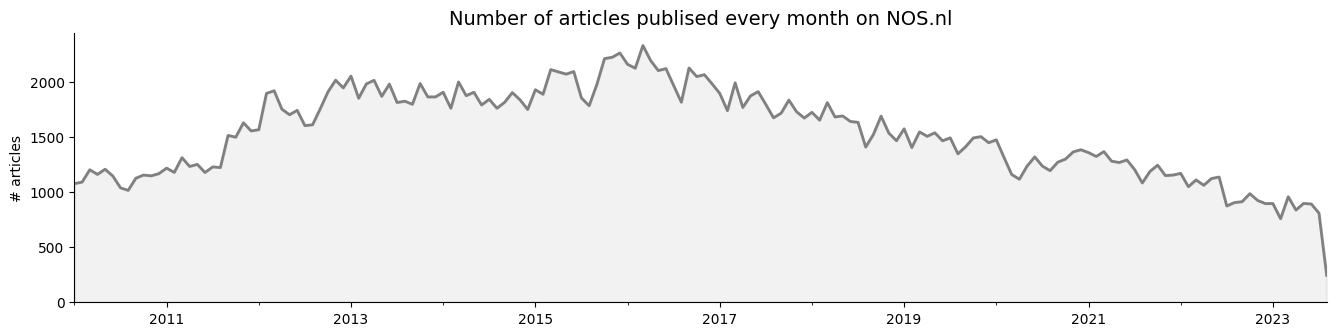

In [25]:
# Intialize figure
fig, ax = plt.subplots(figsize=(14, 4), nrows=1)

# Plot absolute number of acticles over time
all_overtime.plot(ax=ax, legend=None, lw=2, color="gray")
all_overtime.plot(kind="area", ax=ax, legend=None, lw=2, alpha=0.1, color="gray")
ax.set_title("Number of articles publised every month on NOS.nl", fontsize=TITLE_SIZE)
ax.set_ylabel("# articles")
ax.set_ylim(0)

# Despine and tightlayout
sns.despine()
fig.tight_layout(pad=3)

In [26]:


cat_timeseries_normalized.reset_index()#.rename(columns={"category_en": "date"}).to_csv("all.csv", index=None)#.to_csv("normalized.csv")



category_en,index,binnenland,buitenland,cultuur & media,economie,koningshuis,opmerkelijk,politiek,regionaal nieuws,tech
0,2010-01-01,0.377551,0.380334,NaN,0.094620,0.005566,NaN,0.141929,NaN,NaN
1,2010-02-01,0.297619,0.388278,NaN,0.092491,0.005495,NaN,0.216117,NaN,NaN
2,2010-03-01,0.318106,0.400332,NaN,0.077243,0.007475,NaN,0.196844,NaN,NaN
3,2010-04-01,0.351119,0.395869,NaN,0.090361,0.011188,NaN,0.151463,NaN,NaN
4,2010-05-01,0.322581,0.449132,NaN,0.076923,0.003309,NaN,0.148056,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
159,2023-04-01,0.367542,0.391408,0.038186,0.094272,0.005967,0.005967,0.093079,NaN,0.003580
160,2023-05-01,0.370824,0.424276,0.034521,0.108018,NaN,0.002227,0.059020,NaN,0.001114
161,2023-06-01,0.354983,0.425532,0.024636,0.099664,0.001120,0.003359,0.088466,NaN,0.002240
162,2023-07-01,0.333333,0.467901,0.030864,0.104938,NaN,0.001235,0.051852,NaN,0.009877


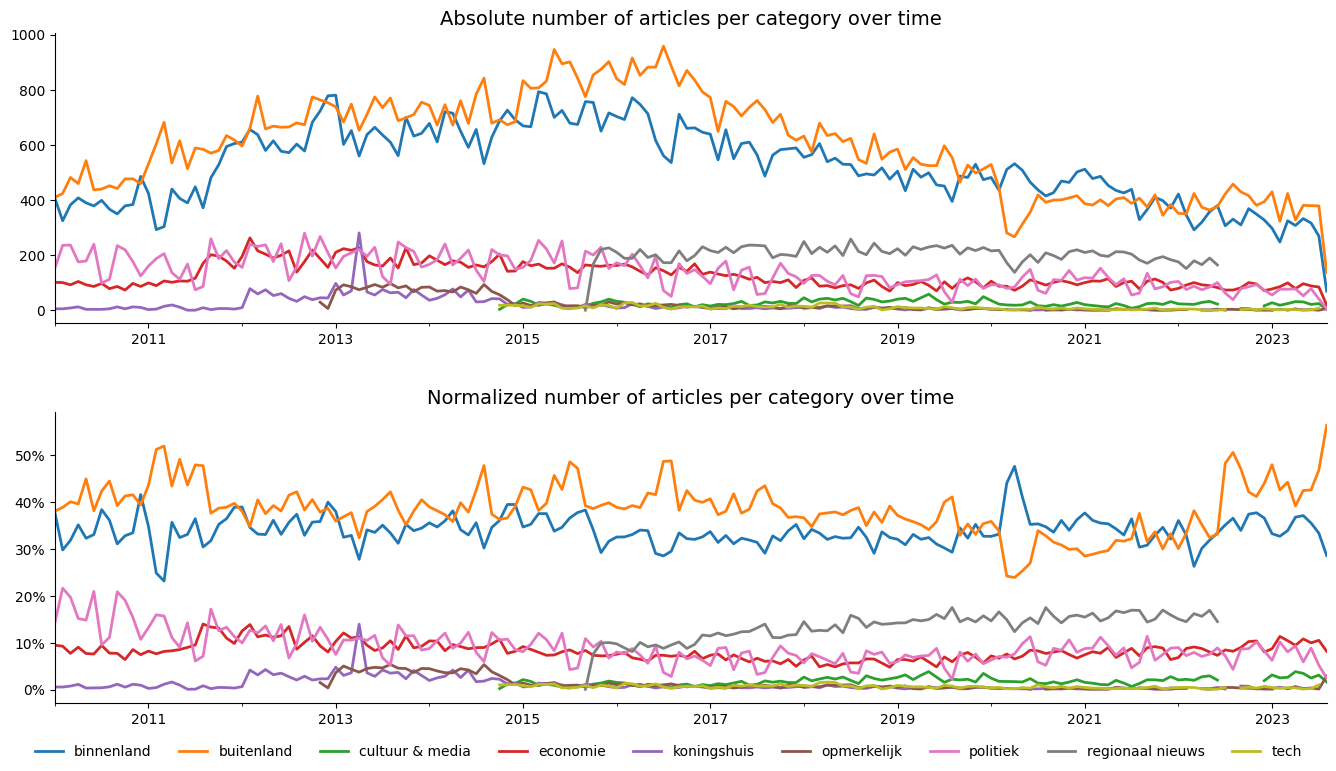

In [27]:
# Intialize figure
fig, ax = plt.subplots(figsize=(14, 8), nrows=2)

# Figure 1: Absolute number of acticles per category
(cat_timeseries_absolute
 .plot(lw=2,
       ax=ax[0],
       legend=None))
ax[0].set_title("Absolute number of articles per category over time", fontsize=TITLE_SIZE)

# Figure 2: Normalized number of acticles per category
(cat_timeseries_normalized
 .plot(lw=2, 
       legend=None, 
       ax=ax[1]) )
ax[1].set_title("Normalized number of articles per category over time", fontsize=TITLE_SIZE)

# Format yaxis ticks as percent
ax[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Only one legend for both axes
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, ncol=10, loc="lower center")

# Despine and tightlayout
sns.despine()
fig.tight_layout(pad=3)

In [28]:
stop_words = list(pd.read_csv("https://raw.githubusercontent.com/stopwords-iso/stopwords-nl/master/stopwords-nl.txt", header=None).values.flatten())

from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF-IDF vectorizer
tfidf = TfidfVectorizer(min_df=0.005, stop_words=stop_words)
tfidf.fit(nos_df.content);


# transform nos_df article text to tfidf vectors
tfidf_vect = tfidf.transform(nos_df.content)

# Store dataframe
tfidf_df = pd.DataFrame(tfidf_vect.toarray(), columns=tfidf.get_feature_names_out())

In [29]:
# Insert category column in TF-IDF matrix
tfidf_df['category_en'] = nos_df.category_en

# Get unqiue categories
categories = tfidf_df['category_en'].unique().tolist()

In [30]:
# Step 1: Filter and update categories for articles containing both terms
natural_disaster_mask = (
    nos_df['content'].str.contains('natuurramp', case=False, na=False) &
    nos_df['content'].str.contains('klimaat', case=False, na=False)
)

# Create a new category called "Natuurrampen"
nos_df.loc[natural_disaster_mask, 'category_en'] = 'Natuurrampen'

# Check if the filtering worked properly
print("Updated Categories:", nos_df['category_en'].unique())

# Check how many articles are in the new category
print("Number of 'Natuurrampen' articles:", nos_df[nos_df['category_en'] == 'Natuurrampen'].shape[0])


Updated Categories: ['buitenland' 'binnenland' 'politiek' 'economie' 'koningshuis'
 'Natuurrampen' 'opmerkelijk' 'tech' 'cultuur & media' 'regionaal nieuws'
 nan]
Number of 'Natuurrampen' articles: 42


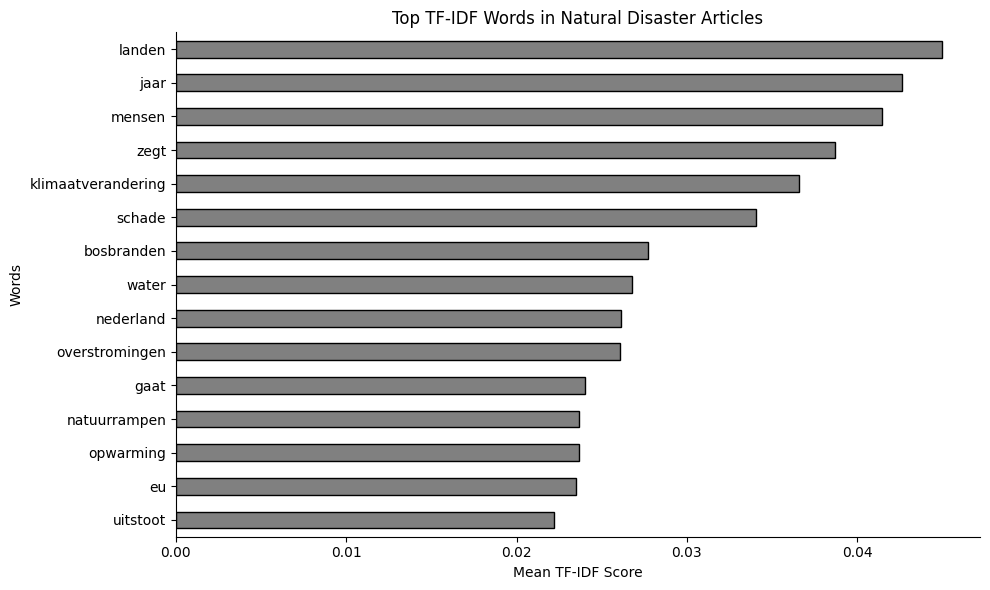

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Filter for natural disaster articles
natural_disaster_df = nos_df[nos_df['category_en'] == 'Natuurrampen']

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(min_df=0.005, stop_words=stop_words)

# Fit and transform only on the filtered dataset
tfidf.fit(natural_disaster_df['content'])
tfidf_vect = tfidf.transform(natural_disaster_df['content'])

# Create DataFrame for TF-IDF values
tfidf_df = pd.DataFrame(tfidf_vect.toarray(), columns=tfidf.get_feature_names_out())

# Calculate the mean TF-IDF scores for all words in natural disaster articles
mean_tfidf = tfidf_df.mean()

# Sort the top 15 words by their mean TF-IDF score
top_words = mean_tfidf.sort_values().tail(15)

# Plot the results
plt.figure(figsize=(10, 6))
top_words.plot(kind="barh", color="gray", edgecolor="k")
plt.title("Top TF-IDF Words in Natural Disaster Articles")
plt.xlabel("Mean TF-IDF Score")
plt.ylabel("Words")
plt.tight_layout()

sns.despine()
plt.show()


In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment of an article
def analyze_sentiment(text):
    score = analyzer.polarity_scores(text)
    # Categorize sentiment
    if score['compound'] >= 0.05:
        return 'Positive', score['compound']
    elif score['compound'] <= -0.05:
        return 'Negative', score['compound']
    else:
        return 'Neutral', score['compound']

# Apply sentiment analysis to the filtered articles
nos_df['sentiment'], nos_df['sentiment_score'] = zip(*nos_df['content'].apply(analyze_sentiment))

# Filter for 'Natuurrampen' articles and print sentiment distribution
disaster_articles = nos_df[nos_df['category_en'] == 'Natuurrampen']
print(disaster_articles[['title', 'sentiment', 'sentiment_score']].head(10))
print("\nSentiment distribution:")
print(disaster_articles['sentiment'].value_counts())


                                                    title sentiment  \
28217                Klimaattop Durban: vraag en antwoord  Negative   
118350  Vijf vragen over de klimaattop: wat is de inze...  Negative   
119308           Wereldleiders komen superlatieven tekort  Negative   
119321  Klimaatakkoord Parijs: waarom lukte het deze k...  Negative   
128624  Hoge koninklijke onderscheiding voor VN-leider...  Negative   
129880     Linten doorknippen is niet genoeg voor Máxima  Negative   
151517  Hoe de natuurramp in Colombia zoveel levens ko...  Negative   
152399  'Als er al vooruitgang is in Noord-Korea, dan ...  Negative   
156534  Dit was het weekend: journalisten vrij, explos...  Negative   
158866  Er is ook hoop, zegt Al Gore met nieuwe klimaa...  Negative   

        sentiment_score  
28217           -0.9593  
118350          -0.7757  
119308          -0.9337  
119321          -0.9829  
128624          -0.9840  
129880          -0.9371  
151517          -0.9136  
152399    

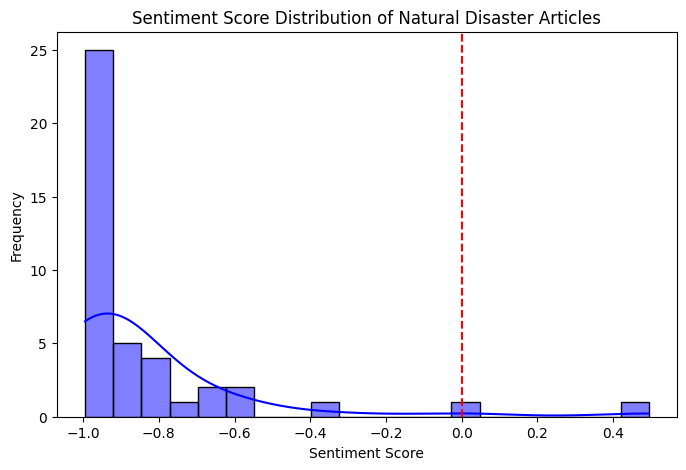

In [33]:
# Histogram for sentiment scores
plt.figure(figsize=(8, 5))
sns.histplot(disaster_articles['sentiment_score'], bins=20, kde=True, color='blue')
plt.title("Sentiment Score Distribution of Natural Disaster Articles")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--')  # Mark the neutral point
plt.show()
